In [ ]:
!git clone https://github.com/Arminkhayati/CovidCT_CNN-


Cloning into 'CovidCT_CNN-'...
remote: Enumerating objects: 2488, done.
remote: Total 2488 (delta 0), reused 0 (delta 0), pack-reused 2488
Receiving objects: 100% (2488/2488), 229.89 MiB | 34.45 MiB/s, done.
Checking out files: 100% (2481/2481), done.


In [ ]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tqdm.notebook import trange, tqdm
import numpy as np
import pandas as pd
import cv2
import time
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
import cv2
import os
import math
import seaborn as sns
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard, LambdaCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import EfficientNetB7, ResNet50


In [ ]:
# params
latent_size = 512
image_size = 256
num_labels = 2
channels = 3
batch_size = 8
train_steps = 200
lr = 2e-4
decay = 6e-8
loss = ['binary_crossentropy', 'categorical_crossentropy']
save_interval = 500

Found 1999 images belonging to 2 classes.
Found 482 images belonging to 2 classes.


(256, 256, 3)

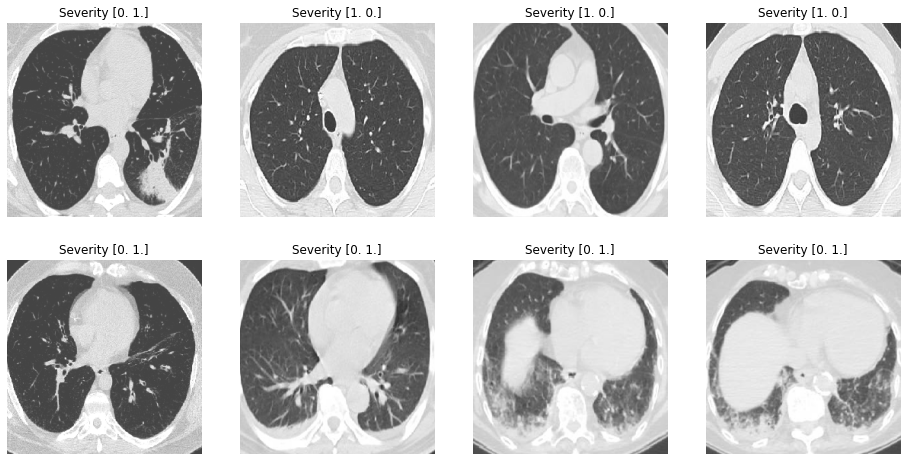

In [ ]:
# https://keras.io/api/preprocessing/image/#flowfromdirectory-method



train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)





train_data = train_datagen.flow_from_directory(
        '/content/CovidCT_CNN-/data/train',
        target_size=(256, 256),
        color_mode="rgb",
        class_mode="categorical",
        shuffle=True,    
        batch_size=batch_size
)

test_data = train_datagen.flow_from_directory(
        '/content/CovidCT_CNN-/data/test',
        target_size=(256, 256),
        color_mode="rgb",
        class_mode="categorical",
        shuffle=False,
        batch_size=batch_size
)




t_x, t_y = train_data.__getitem__(0)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
      c_ax.imshow(np.clip(c_x * 255, 0, 255).astype('int'))
      c_ax.set_title('Severity {}'.format(c_y))
      c_ax.axis('off')

t_x.shape[1:]

In [ ]:
# 
# 
def generator_(noise, labels, image_size):
  num_layers = int(np.log2(image_size)) - 1
  layer_filters = np.flip([2**i if 2**i > 4 else 3 for i in range(2, num_layers + 1) ]) # [128,  64,  32,  16,   8,  3]
  image_resize = image_size // 4
  inp = [noise, labels]
  x = concatenate(inp, axis=1)
  x = Dense(image_resize * image_resize * layer_filters[0])(x)
  x = Reshape((image_resize, image_resize, layer_filters[0]))(x)
  kernel_size = 5
  for f in layer_filters:
    strides = 2 if f > 32 else 1
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(filters=f, kernel_size=kernel_size, strides=strides, padding='same')(x)
  x = Activation('sigmoid')(x)
  return Model(inp, x, name='generator')



noise = Input(shape=(latent_size, ), name='z_input')
labels = Input(shape=(num_labels, ), name='labels')
generator = generator_(noise, labels, image_size)
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z_input (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
labels (InputLayer)             [(None, 2)]          0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 514)          0           z_input[0][0]                    
                                                                 labels[0][0]                     
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 524288)       270008320   concatenate_1[0][0]      

In [ ]:
def discriminator_(inputs, num_labels, image_size):
  kernel_size = 5
  num_layers = int(np.log2(image_size))
  layer_filters = [2**i  for i in range(2, num_layers + 1) if 2**i > 8 ] # [16, 32, 64, 128, 256]
  x = inputs
  for f in layer_filters:
    strides = 2 if f < 128 else 1
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters=f, kernel_size=kernel_size, strides=strides, padding='same')(x)
  
  x = Flatten()(x)
  # probability that the image is real
  prob = Dense(1)(x)
  prob = Activation('sigmoid', name='Real_Fake')(prob)

  # Classification part
  layer = Dense(128)(x)
  layer = Dense(64)(layer)
  labels = Dense(num_labels)(layer)
  labels = Activation('softmax', name='label')(labels)

  # Concat Outputs
  outputs = [prob, labels]
  return Model(inputs, outputs, name='discriminator')


inputs = Input(shape=(image_size, image_size, channels), name='discriminator_input')
discriminator = discriminator_(inputs, num_labels, image_size)
optimizer = RMSprop(learning_rate=lr, decay=decay)
discriminator.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
discriminator_input (InputLayer [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 256, 256, 3)  0           discriminator_input[0][0]        
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 128, 128, 16) 1216        leaky_re_lu_5[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_6 (LeakyReLU)       (None, 128, 128, 16) 0           conv2d_5[0][0]                   
______________________________________________________________________________________

In [ ]:

optimizer = RMSprop(learning_rate=lr*0.5, decay=decay*0.5)
discriminator.trainable = False
adversarial = discriminator(generator([noise, labels]))
adversarial = Model([noise, labels], adversarial, name='ACGAN')
adversarial.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
adversarial.summary()


Model: "ACGAN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z_input (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
labels (InputLayer)             [(None, 2)]          0                                            
__________________________________________________________________________________________________
generator (Functional)          (None, 256, 256, 3)  270692275   z_input[0][0]                    
                                                                 labels[0][0]                     
__________________________________________________________________________________________________
discriminator (Functional)      [(None, 1), (None, 2 34914787    generator[0][0]              

In [ ]:
def plot_images(generator, noise_input, noise_label=None,
                show=False, step=0, model_name="gan"):
  os.makedirs(model_name, exist_ok=True)
  filename = os.path.join(model_name, "%05d.png" % step)
  rows = int(math.sqrt(noise_input.shape[0]))
  noise_input = [noise_input, noise_label]
  images = generator.predict(noise_input)
  plt.figure(figsize=(6, 6))
  num_images = images.shape[0]
  image_size = images.shape[1]
  for i in range(num_images):
    plt.subplot(rows, rows, i + 1)
    image = np.reshape(images[i], [image_size, image_size, channels])
    plt.imshow(image)
    plt.axis('off')
  plt.savefig(filename)
  if show:
      plt.show()
  else:
      plt.close('all')

In [ ]:
noise_input = np.random.normal(loc=0.0, scale=1.0, size=(16, latent_size))
noise_label = np.eye(num_labels)[np.arange(0, 16) % num_labels]

In [ ]:
# noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])

train_steps = 500 # 4600 # 200 # 1500 # * 4
for i in trange(train_steps):

  real_images , real_labels = train_data.next()
  if real_labels.shape[0] != batch_size:
    real_images , real_labels = train_data.next()
  noise = np.random.normal(loc=0.0, scale=1.0, size=(batch_size, latent_size))
  fake_labels = np.eye(num_labels)[np.random.choice(num_labels, batch_size)]
  fake_images = generator.predict([noise, fake_labels])

  x = np.concatenate((real_images, fake_images))
  class_labels = np.concatenate((real_labels, fake_labels)) # labels
  real_fake_labels = np.ones([2 * batch_size, 1]) # y
  real_fake_labels[batch_size:, :] = 0  # 1 is reale 0 is fake

  # Train Discriminator
  discriminator.trainable = True
  metrics1  = discriminator.train_on_batch(x, [real_fake_labels, class_labels])
  

  # Train Adverserial
  discriminator.trainable = False
  noise = np.random.normal(loc=0.0, scale=1.0, size=(batch_size, latent_size))
  class_labels = np.eye(num_labels)[np.random.choice(num_labels, batch_size)] # generate fake class labels
  real_fake_labels = np.ones([batch_size, 1]) # Mark generated fake images as real
  metrics2  = adversarial.train_on_batch([noise, class_labels], [real_fake_labels, class_labels])
  

  if (i + 1) % save_interval == 0:
    plot_images(generator, noise_input=noise_input, noise_label=noise_label,
                show=False, step=(i + 1), model_name="ACGAN")
    info = "%d: [discriminator loss: %f, source loss: %f," 
    info += "label loss: %f, source acc: %f, label acc: %f]" 
    info = info % (i, metrics1[0], metrics1[1], metrics1[2], metrics1[3], metrics1[4])
    print(info)
    info = "%d: [adversarial loss: %f, source loss: %f," 
    info += "label loss: %f, source acc: %f, label acc: %f]" 
    info = info % (i, metrics2[0], metrics2[1], metrics2[2], metrics2[3], metrics2[4])
    print(info)

499: [discriminator loss: 0.016448, source loss: 0.007753,label loss: 0.008695, source acc: 1.000000, label acc: 1.000000]
499: [adversarial loss: 2.901796, source loss: 2.899954,label loss: 0.001842, source acc: 0.000000, label acc: 1.000000]



In [ ]:
generator.save("ACGAN2.h5")

0.09595488   1.0
0.12296282   1.0
0.12999964   1.0
0.106872715   1.0
0.10759492   1.0
0.08466895   1.0
0.13064308   1.0
0.062660635   1.0
0.11177629   1.0
0.07639446   1.0
0.07713754   1.0
0.06210754   1.0
0.096016966   1.0
0.11645769   1.0
0.12654558   1.0
0.03853771   1.0


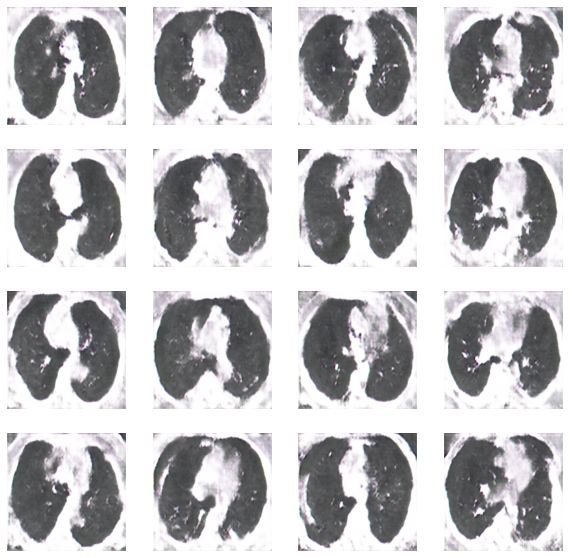

In [ ]:
# noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
# noise_label = np.eye(num_labels)[np.arange(0, 16) % num_labels]
rows = int(math.sqrt(noise_input.shape[0]))
noise_inputs = [noise_input, noise_label]
images = generator.predict(noise_inputs)
plt.figure(figsize=(10, 10))
num_images = images.shape[0]
image_size = images.shape[1]
for i in range(num_images):
  plt.subplot(rows, rows, i + 1)
  image = np.reshape(images[i], [image_size, image_size, channels]) 
  print(image.min(), ' ',image.max())
  plt.imshow(image, cmap = "gray")
  plt.axis('off')
plt.show()

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


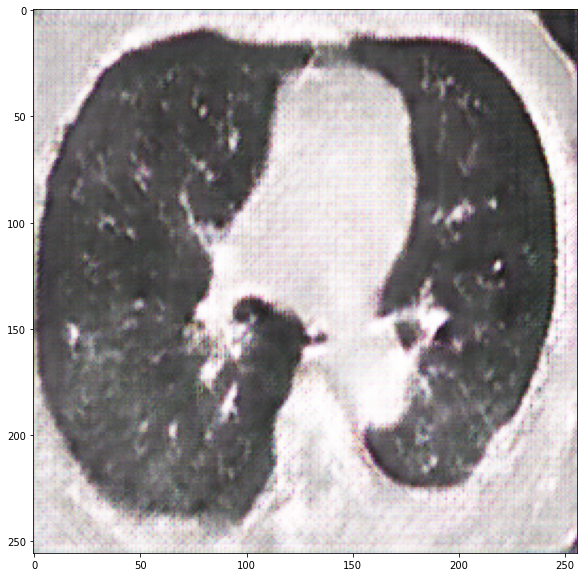

In [ ]:
import matplotlib.image as mpimg
imgplot = plt.imshow(image)
print(noise_label)
plt.show()